In [647]:
import chess
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

SAMPLE_ELOS = [500, 800, 1000, 1200, 1500, 1800, 2000, 2200, 2500]

In [648]:
df = pd.read_parquet("../data/stats_dataset.parquet")
df.tail()

,fen,next_move,games_count,global_avg_elo,global_winrate,engine_move,delta,fragility_score,variance,score,...,is_engine_top3_2200,group_count_2500,winrate_2500,score_2500,recommended_move_2500,historical_best_2500,is_best_2500,is_engine_best_2500,is_top3_2500,is_engine_top3_2500
1098,rnbqkbnr/ppp3pp/4pp2/3p4/3P1B2/4P3/PPP2PPP/RN1...,g1f3,128,1448.312500,0.554688,c2c4,-0.183348,0.159644,0.097174,-0.245818,...,<NA>,NaN,NaN,-0.245818,g1f3,None,<NA>,<NA>,<NA>,<NA>
1099,rnbqkbnr/ppp3pp/5p2/3pP3/5B2/4P3/PPP2PPP/RN1QK...,f6e5,234,1300.923077,0.388889,b8c6,-5.445125,-0.592272,0.605051,-4.247803,...,<NA>,NaN,NaN,-4.247803,f6e5,None,<NA>,<NA>,<NA>,<NA>
1100,rnbqkbnr/ppp3pp/5p2/3pp3/3P1B2/4P3/PPP2PPP/RN1...,d4e5,268,1294.925373,0.570896,d4e5,0.752079,-0.451637,-0.108881,1.094835,...,<NA>,NaN,NaN,1.094835,d4e5,None,<NA>,<NA>,<NA>,<NA>
1101,rnbqkbnr/ppp3pp/8/3pp3/5B2/4P3/PPP2PPP/RN1QKBN...,f4e5,195,1284.076923,0.574359,d1h5,-5.445125,-0.777605,-0.108940,-4.776461,...,<NA>,NaN,NaN,-4.776461,f4e5,None,<NA>,<NA>,<NA>,<NA>
1102,rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR ...,d7d5,145903,1523.417366,0.440176,g8f6,0.284366,-0.788823,-0.174046,0.899143,...,<NA>,629.0,0.500795,0.899143,d7d5,d7d5,True,<NA>,True,<NA>


In [649]:
df.describe()

,games_count,global_avg_elo,global_winrate,delta,fragility_score,variance,score,group_count_500,winrate_500,score_500,...,score_1800,group_count_2000,winrate_2000,score_2000,group_count_2200,winrate_2200,score_2200,group_count_2500,winrate_2500,score_2500
count,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,195.000000,195.000000,1103.000000,...,1103.000000,1095.000000,1095.000000,1103.000000,945.000000,945.000000,1103.000000,393.000000,393.000000,1103.000000
mean,908.332729,1531.509943,0.479422,-0.121262,0.775745,0.273331,-0.623675,4.697436,0.402153,-0.623675,...,-0.623675,88.463927,0.472920,-0.623675,38.967196,0.473131,-0.623675,10.875318,0.511992,-0.623675
std,6679.778021,158.831994,0.064602,1.877036,1.225263,2.042914,2.861197,18.239691,0.426435,2.861197,...,2.861197,651.849711,0.165385,2.861197,272.244788,0.273588,2.861197,49.900229,0.365188,2.861197
min,100.000000,1028.951389,0.172973,-24.933191,-0.825538,-0.176294,-21.652193,1.000000,0.000000,-21.652193,...,-21.652193,1.000000,0.000000,-21.652193,1.000000,0.000000,-21.652193,1.000000,0.000000,-21.652193
25%,133.000000,1414.373582,0.436695,-0.339252,-0.033885,-0.135708,-1.386648,1.000000,0.000000,-1.386648,...,-1.386648,9.000000,0.390774,-1.386648,2.000000,0.333333,-1.386648,1.000000,0.200000,-1.386648
50%,192.000000,1508.982456,0.477387,0.206414,0.532912,-0.050787,-0.436456,1.000000,0.300000,-0.436456,...,-0.436456,18.000000,0.478261,-0.436456,6.000000,0.500000,-0.436456,2.000000,0.500000,-0.436456
75%,364.000000,1634.374101,0.523540,0.596175,1.346759,0.175883,0.347831,2.000000,1.000000,0.347831,...,0.347831,39.000000,0.555556,0.347831,18.000000,0.600000,0.347831,5.000000,0.833333,0.347831
max,145903.000000,2151.609195,0.844221,2.506005,7.074279,55.085881,55.244096,176.000000,1.000000,55.244096,...,55.244096,14145.000000,1.000000,55.244096,5431.000000,1.000000,55.244096,629.000000,1.000000,55.244096


In [650]:
results = []
grouped = df.groupby("fen").first().reset_index()


def weighted_mean(values, weights):
    mask = values.notna() & weights.notna()
    if mask.sum() == 0:
        return float("nan")
    return (values[mask] * weights[mask]).sum() / weights[mask].sum()


for elo in SAMPLE_ELOS:
    is_best_col = f"is_best_{elo}"
    is_engine_col = f"is_engine_best_{elo}"
    is_top3_col = f"is_top3_{elo}"
    is_engine_top3_col = f"is_engine_top3_{elo}"
    group_count_col = f"group_count_{elo}"

    avg_is_best = grouped[is_best_col].mean(skipna=True)
    avg_is_engine_best = grouped[is_engine_col].mean(skipna=True)
    avg_is_top3_best = grouped[is_top3_col].mean(skipna=True)
    avg_is_engine_top3_best = grouped[is_engine_top3_col].mean(skipna=True)

    weighted_avg_is_best = weighted_mean(grouped[is_best_col], grouped[group_count_col])
    weighted_avg_is_engine_best = weighted_mean(grouped[is_engine_col], grouped[group_count_col])
    weighted_avg_is_top3_best = weighted_mean(grouped[is_top3_col], grouped[group_count_col])
    weighted_avg_is_engine_top3_best = weighted_mean(grouped[is_engine_top3_col], grouped[group_count_col])

    results.append({
        "elo": elo,
        "avg_is_best": avg_is_best,
        "avg_is_engine_best": avg_is_engine_best,
        "avg_is_top3": avg_is_top3_best,
        "avg_is_engine_top3": avg_is_engine_top3_best
    })

pd.DataFrame(results)

,elo,avg_is_best,avg_is_engine_best,avg_is_top3,avg_is_engine_top3
0,500,0.500000,0.000000,0.500000,0.500000
1,800,0.393443,0.333333,0.590164,0.537037
2,1000,0.593023,0.575916,0.879845,0.837696
3,1200,0.682500,0.600000,0.917500,0.905455
4,1500,0.742747,0.670659,0.943907,0.913174
5,1800,0.695364,0.608553,0.931567,0.917763
6,2000,0.613475,0.533679,0.897163,0.844560
7,2200,0.547826,0.411765,0.800000,0.800000
8,2500,0.222222,0.187500,0.777778,0.812500


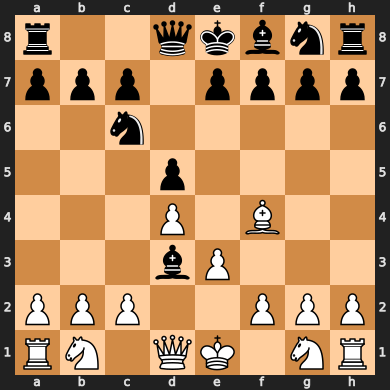

In [651]:
random_fen = df["fen"].sample(1).iloc[0]
filtered = df[df["fen"] == random_fen]
chess.Board(random_fen)

In [652]:
print(random_fen)

r2qkbnr/ppp1pppp/2n5/3p4/3P1B2/3bP3/PPP2PPP/RN1QK1NR w KQkq - 0 5


In [653]:
filtered.drop("fen", axis=1).set_index('next_move').T

next_move,d1d3
games_count,825
global_avg_elo,1428.425455
global_winrate,0.523636
engine_move,d1d3
delta,0.596175
...,...
historical_best_2500,None
is_best_2500,<NA>
is_engine_best_2500,<NA>
is_top3_2500,<NA>


In [654]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103 entries, 0 to 1102
Data columns (total 91 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fen                    1103 non-null   object 
 1   next_move              1103 non-null   object 
 2   games_count            1103 non-null   int64  
 3   global_avg_elo         1103 non-null   float64
 4   global_winrate         1103 non-null   float64
 5   engine_move            1103 non-null   object 
 6   delta                  1103 non-null   float64
 7   fragility_score        1103 non-null   float64
 8   variance               1103 non-null   float64
 9   score                  1103 non-null   float64
 10  group_count_500        195 non-null    float64
 11  winrate_500            195 non-null    float64
 12  score_500              1103 non-null   float64
 13  recommended_move_500   1103 non-null   object 
 14  historical_best_500    409 non-null    object 
 15  is_b

In [655]:
df["f_cross_d"] = df["fragility_score"] * df["delta"]
df["f_cross_v"] = df["fragility_score"] * df["variance"]
df["d_cross_v"] = df["delta"] * df["variance"]

df_reg = df[pd.notna(df["is_best_1500"])]
selected_features = ["fragility_score", "delta", "variance", "f_cross_d", "f_cross_v", "d_cross_v"]
X = df_reg[selected_features]
y = df_reg["is_best_1500"].fillna(False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [656]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
acc_log = accuracy_score(y_test, y_pred_log)
print(f"Logistic Regression Accuracy: {acc_log:.3f}")

Logistic Regression Accuracy: 0.548


In [657]:
print("Logistic Regression Coefficients:")
for feature, coef in zip(selected_features, log_model.coef_[0]):
    print(f"{feature}: {coef:.3f}")

Logistic Regression Coefficients:
fragility_score: 0.224
delta: 0.366
variance: 0.293
f_cross_d: -0.074
f_cross_v: -0.073
d_cross_v: -0.061


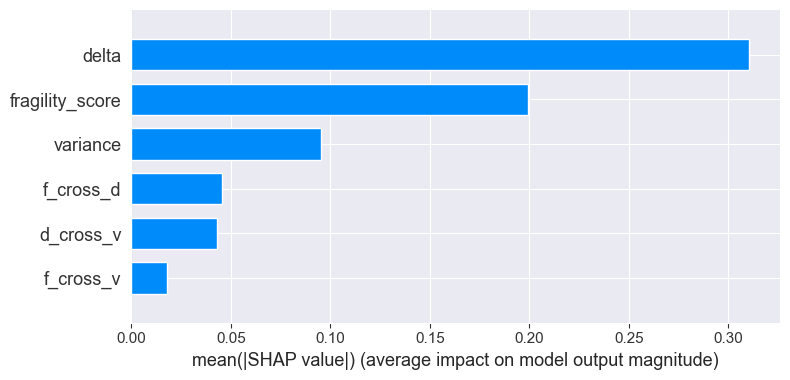

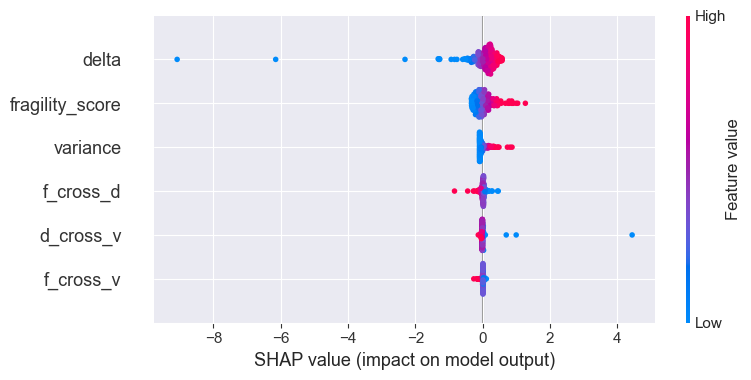

In [658]:
explainer_log = shap.Explainer(log_model, X_train)
shap_values_log = explainer_log(X_test)
shap.summary_plot(shap_values_log, features=X_test, feature_names=selected_features, plot_type="bar")
shap.summary_plot(shap_values_log, features=X_test, feature_names=selected_features, show=True)

In [659]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {acc_xgb:.3f}")

XGBoost Accuracy: 0.556


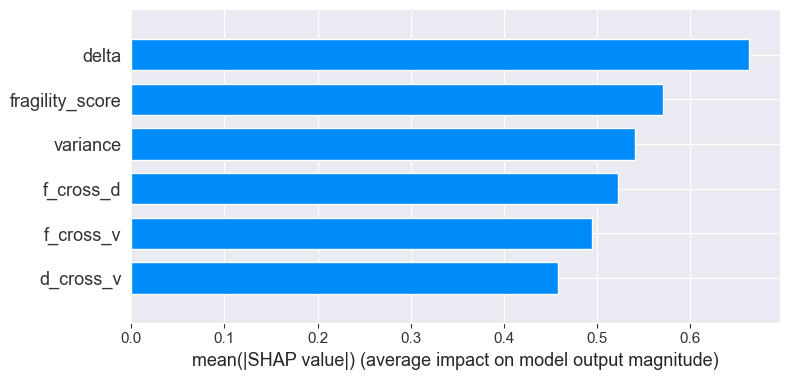

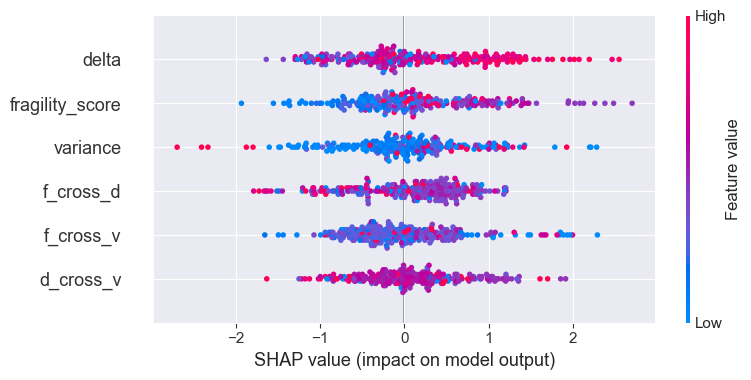

In [660]:
explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_test)
shap.summary_plot(shap_values_xgb, features=X_test, feature_names=selected_features, plot_type="bar")
shap.summary_plot(shap_values_xgb, features=X_test, feature_names=selected_features, show=True)